In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.problems.functional import FunctionalProblem

from tqdm import tqdm


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay


from utils import plot_proba

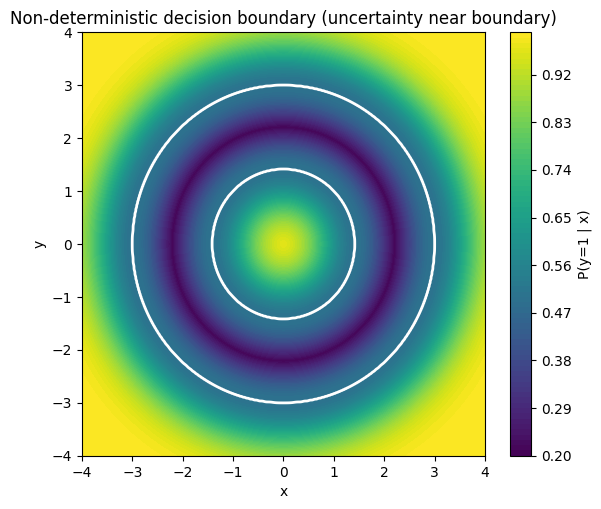

e:\Thieses mit Thies\src\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28176 (\N{CJK UNIFIED IDEOGRAPH-6E10}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Thieses mit Thies\src\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


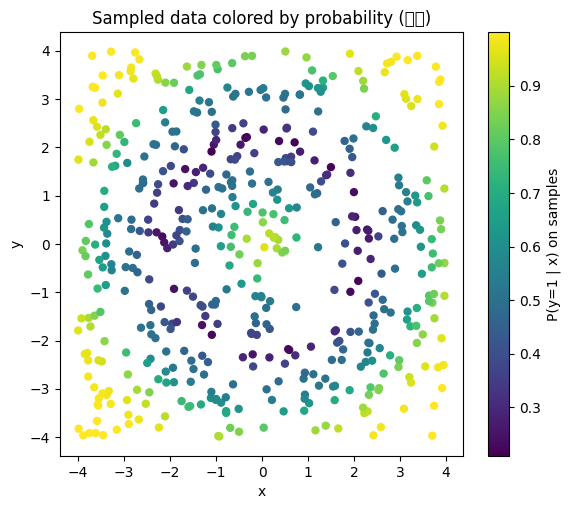

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# -------------------------------------------
# 1) Boundary-focused probabilistic boundary
# -------------------------------------------
def decision_prob_boundary_focus(
    x, y,
    r_inner=np.sqrt(2), r_outer=3.0,
    sigma=0.85,            # width of uncertain band around boundary
    max_uncertainty=1.0    # 1.0 -> p=0.5 exactly on boundary
):
    """
    Non-deterministic P(y=1|x) with uncertainty emphasized near boundaries.

    Hard rule:
        y=1 if r<=r_inner or r>=r_outer   (inside inner disk OR outside outer disk)
        y=0 otherwise (annulus)
    Then we add boundary uncertainty:
        closer to boundary -> p moves toward 0.5
        far away -> p -> hard label (0 or 1)
    """
    r = np.sqrt(x**2 + y**2)

    # hard/deterministic label
    base = 1.0 if (r <= r_inner or r >= r_outer) else 0.0

    # distance to nearest boundary
    dist_to_boundary = min(abs(r - r_inner), abs(r - r_outer))

    # uncertainty weight peaked at boundary (Gaussian bump)
    alpha = max_uncertainty * np.exp(-(dist_to_boundary / sigma)**2)

    # blend base toward 0.5 near boundary
    p = base * (1 - alpha) + 0.5 * alpha
    return float(np.clip(p, 0.0, 1.0))


def generate_data(n=300, prob_fn=decision_prob_boundary_focus, xlim=(-4, 4), rng=None):
    """
    Sample X uniformly, then sample Y ~ Bernoulli(p).
    Returns X, Y, p1 (probability for class 1).
    """
    rng = np.random.default_rng() if rng is None else rng
    X = rng.uniform(xlim[0], xlim[1], size=(n, 2))
    p1 = np.array([prob_fn(x, y) for x, y in X])
    Y = rng.binomial(1, p1).astype(np.int64)
    return X, Y, p1


# -------------------------------------------
# 2) Gradient visualization of P(y=1|x)
# -------------------------------------------
def plot_probabilistic_boundary(prob_fn, xlim=(-4, 4), grid_n=450):
    xs = np.linspace(xlim[0], xlim[1], grid_n)
    ys = np.linspace(xlim[0], xlim[1], grid_n)
    xx, yy = np.meshgrid(xs, ys)

    # evaluate probability field
    pp = np.vectorize(prob_fn)(xx, yy)

    plt.figure(figsize=(6.5, 5.5))
    # 渐变 color map showing probability
    cf = plt.contourf(xx, yy, pp, levels=80, cmap="viridis")
    plt.colorbar(cf, label="P(y=1 | x)")

    # emphasize the "closing decision boundary area" by drawing p=0.5 contour
    plt.contour(xx, yy, pp, levels=[0.5], colors="white", linewidths=2)

    plt.title("Non-deterministic decision boundary (uncertainty near boundary)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()


# ---- run / demo ----
plot_probabilistic_boundary(decision_prob_boundary_focus)

X, Y, p1 = generate_data(500)

plt.figure(figsize=(6.5, 5.5))
plt.scatter(X[:, 0], X[:, 1], c=p1, s=25, cmap="viridis")
plt.colorbar(label="P(y=1 | x) on samples")
plt.title("Sampled data colored by probability (渐变)")
plt.xlabel("x"); plt.ylabel("y")
plt.show()


In [3]:


# -----------------------------
# 2) Train classifier
# -----------------------------


device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(Y, dtype=torch.long))
# X, Y = sklearn.datasets.make_moons(n_samples=300, noise=0.1, random_state=42)
# X = torch.tensor(X, dtype=torch.float32)
# Y = torch.tensor(Y, dtype=torch.long)
# dataset = TensorDataset(X, Y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)


model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# training loop
num_epochs = 200

bar = tqdm(range(num_epochs), desc="Training", ncols=80, unit="epoch",colour="blue")
for epoch in bar:
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    bar.set_postfix({'Train Loss': epoch_loss})

# Validation
model.eval()
val_loss = 0.0
correct = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

val_loss /= len(val_loader.dataset)
val_accuracy = correct / len(val_loader.dataset)

bar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss, 'Val Acc': val_accuracy})


Training: 100%|██████████| 100/100 [00:03<00:00, 26.99epoch/s, Train Loss=0.538]


(<Figure size 520x460 with 2 Axes>,
 <Axes: title={'center': 'Class 1 probability surface'}, xlabel='x0', ylabel='x1'>)

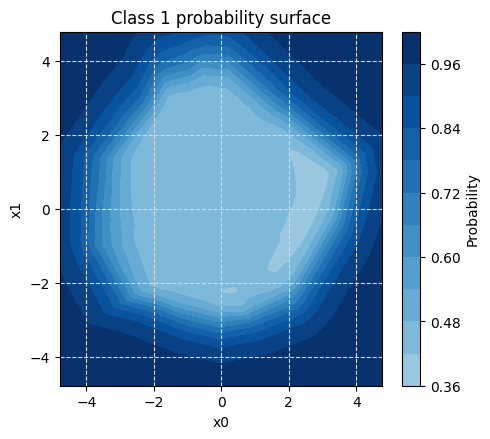

In [5]:
# visual

plot_proba(model, X,levels=10)

Let $x^{cf} \in X^{CF}$. 
Denote by $x^{[1]},\dots,x^{[k]} \in X_{\text{obs}}$ the $k$-nearest observed neighbors of $x^{cf}$.
We define the $O_4$ plausibility as
$$
o_4\!\left(x^{cf}, X_{\mathrm{obs}}\right)
= \sum_{i=1}^{k} w_{[i]} \,\frac{1}{p}\sum_{j=1}^{p} \delta_{G}\!\left(x_j^{cf}, x_{j}^{[i]}\right),
$$
where $p=\dim(x)$ is the number of features for any $x \in X$, and
$$
\delta_G(u,v)=
\begin{cases}
R_j\,\lvert u - v \rvert, & \text{if feature } j \text{ is numerical},\\[4pt]
\mathbb{I}[u \neq v], & \text{if feature } j \text{ is categorical}.
\end{cases}
$$
Here $u$ and $v$ denote the $j$-th feature values being compared, and
$$
R_j = \max\!\left(X_{:,j}\right) - \min\!\left(X_{:,j}\right)
$$
is the empirical range of feature $j$ over the dataset $X$ (or $X_{\text{obs}}$, if preferred).


In [6]:

# -----------------------------
# 3) Multi-objective CF problem
# -----------------------------
def make_cf_problem(model, x_star, Y_prime, X_obs, weights, k=5):
    model.eval()

    x_star_np = x_star.detach().cpu().numpy()
    X_obs_np = X_obs.detach().cpu().numpy()
    w_np = weights.detach().cpu().numpy()
    w_np = w_np / (w_np.sum() + 1e-12)

    p = x_star_np.shape[0]

    xl = X_obs_np.min(axis=0)
    xu = X_obs_np.max(axis=0)
    feature_range = xu - xl
    feature_range[feature_range == 0] = 1.0

    target_labels = Y_prime.view(-1).long().tolist()

    def delta_G_vec(x, y):
        return np.minimum(np.abs(x - y) / feature_range, 1.0)
    
    def k_nearest(x, k=5):
        dists = np.linalg.norm(X_obs_np - x, axis=1)
        nearest_indices = np.argsort(dists)[:k]
        return X_obs_np[nearest_indices]

    # 1) Validity: distance to target in probability space
    def o1_validity(x):
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x_t).argmax(dim=1).item()
        return 0.0 if pred in target_labels else 1.0

    # 2) Similarity
    def o2_similarity(x):
        return float(delta_G_vec(x, x_star_np).mean())

    # 3) Sparsity (L0)
    EPS = 0.005
    def o3_sparsity(x):
        diff=0
        for i in range(len(x_star_np)):
            if abs(x[i] - x_star_np[i]) > EPS:
                diff += 1
        return float(diff)     

    def o4_plausibility(x):
    # mean Gower distance to k nearest obs sample, then weighted sum
        nearest_samples = k_nearest(x, k=5)
        per_sample = np.array([delta_G_vec(x, x_i).mean()
                            for x_i in nearest_samples])
        return float((per_sample * w_np).sum())


    return FunctionalProblem(
        n_var=p,
        objs=[o1_validity, o2_similarity, o3_sparsity, o4_plausibility],
        xl=xl, xu=xu,
        elementwise=True
    )
    


In [7]:

# pick a REAL observed instance as x*
x_star = dataset.tensors[0][0].to(device)
with torch.no_grad():
    y_star = model(x_star.unsqueeze(0)).argmax(dim=1)
Y_prime = 1 - y_star  # binary case

X_obs = dataset.tensors[0].to(device)
k=5
weights = torch.ones(k)
problem = make_cf_problem(model, x_star, Y_prime, X_obs, weights, k=k)

x_star,y_star,Y_prime

(tensor([ 1.7447, -0.4078], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([1], device='cuda:0'))

In [8]:



algorithm = NSGA2(pop_size=200)
termination = get_termination("n_gen", 150)

# no seed => nondeterministic search
res = minimize(problem, algorithm, termination, verbose=True)

F_mmo, X_mmo = res.F, res.X



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     13 |             - |             -
     2 |      400 |     20 |  0.1190699629 |         nadir
     3 |      600 |     26 |  0.0169523046 |         nadir
     4 |      800 |     24 |  0.0630535004 |         nadir
     5 |     1000 |     32 |  0.0072848299 |         nadir
     6 |     1200 |     41 |  0.0118355743 |             f
     7 |     1400 |     50 |  0.0140128716 |             f
     8 |     1600 |     59 |  0.0097419840 |             f
     9 |     1800 |     66 |  0.0103492021 |         nadir
    10 |     2000 |     76 |  0.0030568779 |             f
    11 |     2200 |     88 |  0.0076489245 |             f
    12 |     2400 |    102 |  0.0008005177 |             f
    13 |     2600 |    114 |  0.0102881371 |         nadir
    14 |     2800 |    129 |  0.0012475648 |             f
    15 |     3000 |    141 |  0.0033452891 |             f
    16 |     3200 |    157 |  0.5000000000 |         ide

In [9]:
valided_F_mmo=np.array([f for f in F_mmo if f[0]<=0.5])
valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]<=0.5])
not_valided_F_mmo=np.array([f for f in F_mmo if f[0]>=0.5])
not_valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]>=0.5])
valided_F_mmo.shape,valided_X_mmo.shape,not_valided_F_mmo.shape,not_valided_X_mmo.shape

((105, 4), (105, 2), (95, 4), (95, 2))

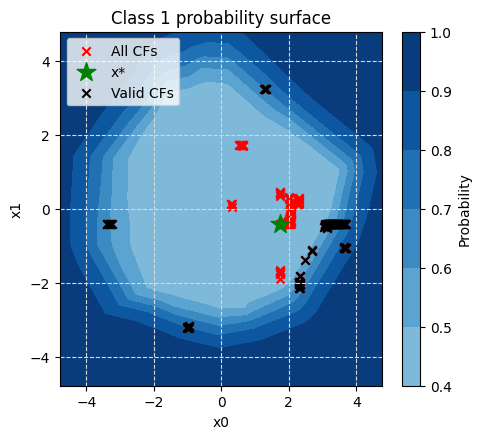

In [10]:

# -----------------------------
# 4) Post-processing & plots
# -----------------------------
# With prob-based validity, use threshold instead of ==0.
# valid_mask = F_mmo[:, 0] < 0.05  # e.g. at least 95% target prob
# valid_F = F_mmo[valid_mask]
# valid_X = X_mmo[valid_mask]

# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], c=Y, label="Original data", s=15, cmap="coolwarm")
# plt.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
# plt.scatter(valid_X[:, 0], valid_X[:, 1], c="black", marker="x", label="Valid CFs")
# plt.scatter(x_star[0].item(), x_star[1].item(),
#             c="green", marker="*", s=200, label="x*")
# plt.legend()
# plt.show()


fig,ax=plot_proba(model, X,levels=5)
ax.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
ax.scatter(x_star[0].item(), x_star[1].item(),
           c="green", marker="*", s=200, label="x*")
# scatter valid CFs if any
if valided_X_mmo.shape[0] > 0:
    ax.scatter(valided_X_mmo[:, 0], valided_X_mmo[:, 1],
               c="black", marker="x", label="Valid CFs")

ax.legend()
plt.show()

In [11]:
poi=np.array([4,2.6676])
problem.objs[1](poi), x_star

(0.3344889064214902, tensor([ 1.7447, -0.4078], device='cuda:0'))

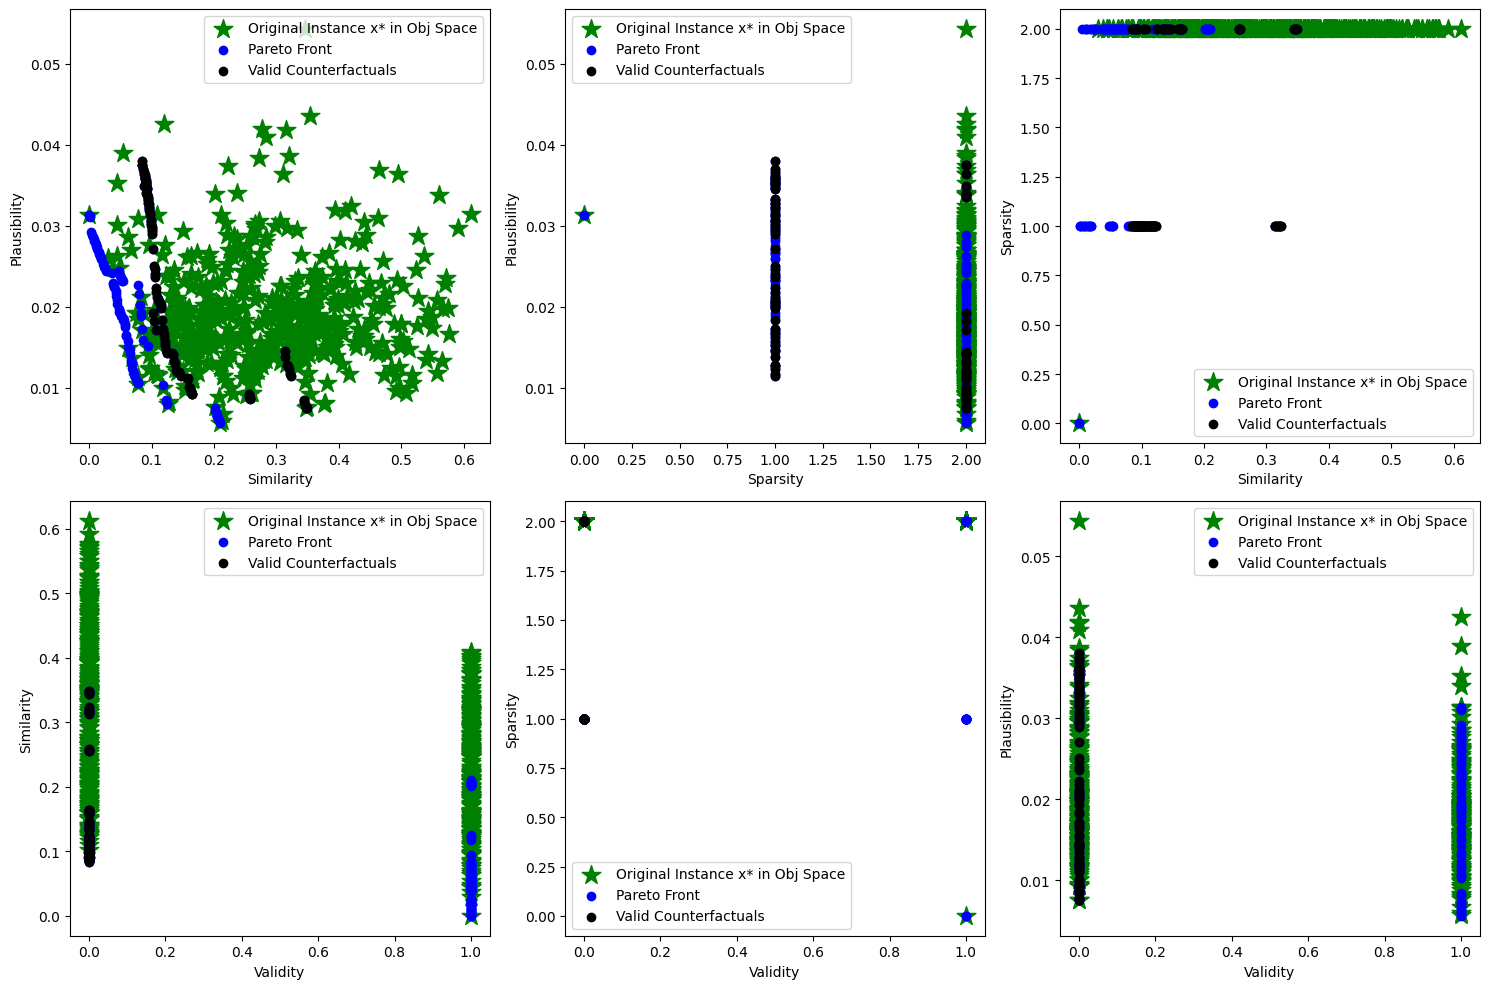

In [12]:
# visualize the Pareto front in objective space
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Create pairs of objective indices to plot
obj_pairs = [(1, 3), (2, 3), (1, 2), (0, 1), (0, 2), (0, 3)]
obj_labels = ['Validity', 'Similarity', 'Sparsity', 'Plausibility']

for i, (obj_x, obj_y) in enumerate(obj_pairs):
    row = i // 3
    col = i % 3
    ax[row, col].scatter(problem.evaluate(X)[:, obj_x],
                         problem.evaluate(X)[:, obj_y],
                         marker='*', c='green', s=200, label='Original Instance x* in Obj Space')
    ax[row, col].scatter(F_mmo[:, obj_x], F_mmo[:, obj_y], c='blue', label='Pareto Front')
    ax[row, col].scatter(valided_F_mmo[:, obj_x], valided_F_mmo[:, obj_y], c='black', label='Valid Counterfactuals')
    ax[row, col].set_xlabel(obj_labels[obj_x])
    ax[row, col].set_ylabel(obj_labels[obj_y])
    ax[row, col].legend()

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

F_X = problem.evaluate(X)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=problem.evaluate(X)[:,1], y=problem.evaluate(X)[:,2], z=problem.evaluate(X)[:,3],
    mode='markers',
    marker=dict(color='green', size=6, opacity=0.2),
    name='Original observations in Obj Space'
))

fig.add_trace(go.Scatter3d(
    x=not_valided_F_mmo[:,1], y=not_valided_F_mmo[:,2], z=not_valided_F_mmo[:,3],
    mode='markers',
    marker=dict(color='blue', size=3, opacity=0.2),
    name='Pareto Front which not valid'
))

fig.add_trace(go.Scatter3d(
    x=valided_F_mmo[:,1], y=valided_F_mmo[:,2], z=valided_F_mmo[:,3],
    mode='markers',
    marker=dict(color='red', size=5, symbol='cross'),
    name='Valid Counterfactuals in Obj Space'
))


# add the fixed x_star point
fig.add_trace(go.Scatter3d(
    x=[F_X[0,1]], y=[F_X[0,2]], z=[F_X[0,3]],
    mode='markers',
    marker=dict(color='purple', size=6),
    name='Factual Instance x* in Obj Space'
))

fig.update_layout(
    scene=dict(
        xaxis_title='similarity/AU',
        yaxis_title='sparsity',
        zaxis_title='plausibility'
    ),
    width=900, height=700
)

fig.show()

# 可选：保存成可交互 html
fig.write_html("pareto_front_3d.html")
